In [19]:
using Phylo, Plots, FASTX, MolecularEvolution, CodonMolecularEvolution, JLD2, MCMCChains, StatsPlots, MCMCDiagnosticTools, Measures

In [24]:
analysis_name = "output/Ace2"
seqnames,seqs = read_fasta("../test/data/Ace2_tiny/Ace2_tiny_tagged.fasta");
treestring, tags, tag_colors = import_colored_figtree_nexus_as_tagged_tree("../test/data/Ace2_tiny/Ace2_tiny_tagged_no_bg.nex")
df,results = difFUBAR(seqnames, seqs, treestring, tags, analysis_name);

Step 1: Initialization. If exports = true, tree showing the assignment of branches to groups/colors will be exported to: output/Ace2_tagged_input_tree.svg.
Step 2: Optimizing global codon model parameters.
Optimized single α,β LL=-17461.80292552851 with α=1.688175953772318 and β=0.830522823141943.
Step 3: Calculating grid of 1728-by-808 conditional likelihood values (the slowest step). Currently on:
0.0% 29.0% 58.0% 87.0% 
Step 4: Running Gibbs sampler to infer site categories.
Step 5: Tabulating and plotting. Detected sites:
Site 3 - P(ω1 > ω2):0.008; P(ω2 > ω1):0.963; P(ω1 > 1):0.188; P(ω2 > 1):0.9355
Site 29 - P(ω1 > ω2):0.9755; P(ω2 > ω1):0.002; P(ω1 > 1):0.9725; P(ω2 > 1):0.1715
Site 36 - P(ω1 > ω2):0.9685; P(ω2 > ω1):0.002; P(ω1 > 1):0.917; P(ω2 > 1):0.246
Site 68 - P(ω1 > ω2):0.9735; P(ω2 > ω1):0.002; P(ω1 > 1):0.354; P(ω2 > 1):0.02
Site 69 - P(ω1 > ω2):0.3665; P(ω2 > ω1):0.2575; P(ω1 > 1):0.955; P(ω2 > 1):0.9185
Site 93 - P(ω1 > ω2):0.801; P(ω2 > ω1):0.0495; P(ω1 > 1):0.9545; P

In [4]:
include("../src/difFUBAR/skbDifFUBAR.jl")

main (generic function with 1 method)

In [5]:
@load "../output/alloc_grid.jld2" alloc_grid
@load "../output/ambient_samples.jld2" ambient_samples
@load "../output/model.jld2" model_dict 


1-element Vector{Symbol}:
 :model_dict

In [6]:
square_distance_matrix = generate_square_l2_distance_matrix(model_dict[:codon_param_index_vec])
kernel_stddev = 1.0 # example values idk what these should be xD
suppression_stddev = 1.0
model = SKBDIModel(
    model_dict[:parameter_grids],
    model_dict[:parameter_names],
    model_dict[:hypothesis_masks],
    s -> CodonMolecularEvolution.quintic_smooth_transition(-1, 1, s),
    model_dict[:log_con_lik_matrix],
    model_dict[:con_lik_matrix],
    model_dict[:codon_param_vec],
    model_dict[:codon_param_index_vec],
    s -> hedwigs_ambient_to_parameter_transform(
                s,
                model_dict[:kernel_dim],
                model_dict[:suppression_dim],
                kernel_stddev,
                suppression_stddev,
                square_distance_matrix,
                fast_cov_mat_hedwigs_kernel),
    1)

SKBDIModel([[0.009999999999999995, 0.07271870467705141, 0.20099800796022266, 0.46336917355664603, 1.0, 2.0975773318483997, 4.342465139303896, 8.933960537241305], [0.009999999999999995, 0.07271870467705141, 0.20099800796022266, 0.46336917355664603, 1.0, 2.0975773318483997, 4.342465139303896, 8.933960537241305], [0.05, 0.16897595699439444, 0.4295046974161089, 1.0, 2.249247548441142, 4.984799322869144]], ["alpha", "omega_1", "omega_2", "background_omega"], Bool[0 0 … 1 1; 0 0 … 1 1; 0 0 … 0 0; 0 0 … 0 0], var"#39#41"(), [-3.840116596383576 -27.126453480219148 … -47.94676925041362 -21.72547919316213; -3.8429970136890934 -24.69243608840445 … -47.94849744267823 -20.509713715303707; … ; -85.43626341516443 -84.93040695782629 … -93.5836205345817 -82.40415733571044; -88.8505859369693 -89.86531913443119 … -97.31823155778113 -85.44550320956503], [1.0 1.2004942822494321e-6 … 6.219050670345792e-11 7.667068681741002e-5; 0.9971237271162332 1.3691165429671057e-5 … 6.208312236795611e-11 0.00025860063800

In [7]:
ambient_sample_mat = reduce(hcat, ambient_samples)
#ambient_sample_mat[output_grid.kernel_dim + 1:model_dict[:kernel_dim + model_dict[:suppression_dim, :]
ambient_sample_mat = permutedims(ambient_sample_mat, (2, 1))        # 3D: iterations × parameters × chains
print(size(ambient_sample_mat))
ambient_sample_mat = reshape(ambient_sample_mat, size(ambient_sample_mat)..., 1)
#=param_names = [:θ1, :θ2, :θ3, :θ4]
chain = Chains(vals, param_names) =#
println(model_dict[:kernel_dim])
println(model_dict[:suppression_dim])

(10000, 3077)1
4


In [21]:
F = s -> CodonMolecularEvolution.quintic_smooth_transition(s, -1, 1)
s_values = -1 .+ 2/ 500 .* (1:500) 
F_values = F.(s_values)
hypothesis_names = ["ω_1>1", "ω_2>1", "ω_1>ω_2", "ω_2>ω_1"]
F = s -> CodonMolecularEvolution.quintic_smooth_transition(s, -1, 1)
p1 = plot(s_values, F_values, label="F(s)", title="Transition Function", xlabel="suppression parameter value", ylabel="Value")
chn = Chains(ambient_sample_mat[:, model_dict[:kernel_dim] + 1:model_dict[:kernel_dim] + model_dict[:suppression_dim], :], hypothesis_names)
p2 = plot(chn)
p3 = plot(autocor(chn[hypothesis_names[1]]), label=hypothesis_names[1], title="Autocorrelation of Chains", xlabel="Lag", ylabel="Autocorrelation")
for i in 2:length(hypothesis_names)
    plot!(autocor(chn[hypothesis_names[i]]), label=hypothesis_names[i])
end
p4 = plot(1:length(LL), LL, label="Log-Likelihoods", title="Log-Likelihoods over iterations", xlabel="Iteration", ylabel="Log-Likelihood")
plot(p1, p2, p3, p4, layout = @layout([a{0.1h}; b; c{0.1h}; d{0.1h}]), size =(800, 1.6 * 800), left_margin = 10mm,  right_margin = 10mm)
savefig("mcmc_diagnostics.pdf")

"c:\\Users\\toven\\Documents\\tove-code\\CodonMolecularEvolution.jl-1\\faffing_about\\mcmc_diagnostics.pdf"

In [22]:
for i = 1:model_dict[:suppression_dim]
    println("P(F(s) > 0) for hypothesis ", hypothesis_names[i], ") = ", mean([F(a[model_dict[:kernel_dim] + i]) > 0 for a in ambient_samples[1000:end]]))
end

P(F(s) > 0) for hypothesis ω_1>1) = 1.0
P(F(s) > 0) for hypothesis ω_2>1) = 0.25308299077880236
P(F(s) > 0) for hypothesis ω_1>ω_2) = 1.0
P(F(s) > 0) for hypothesis ω_2>ω_1) = 0.2957449172314187


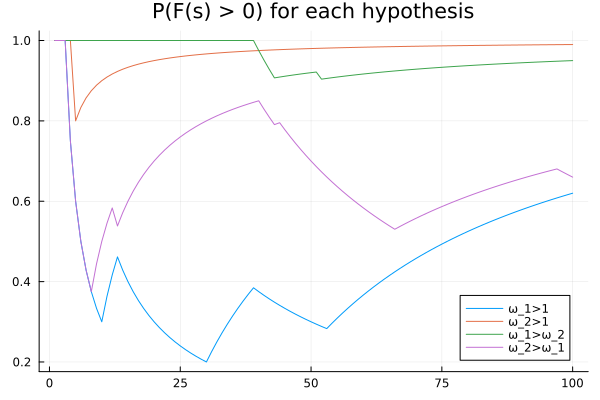

In [ ]:
f = (i, j) -> mean([F(ambient_samples[k][model_dict[:kernel_dim] + i]) > 0 for k in 1:j])
p1 = plot(1:10000, f.(1, 1:100), label=hypothesis_names[1], title="P(F(s) > 0) for each hypothesis")
for i in 2:model_dict[:suppression_dim]
    plot!(1:10000, f.(i, 1:100), label=hypothesis_names[i])
end
display(p1)

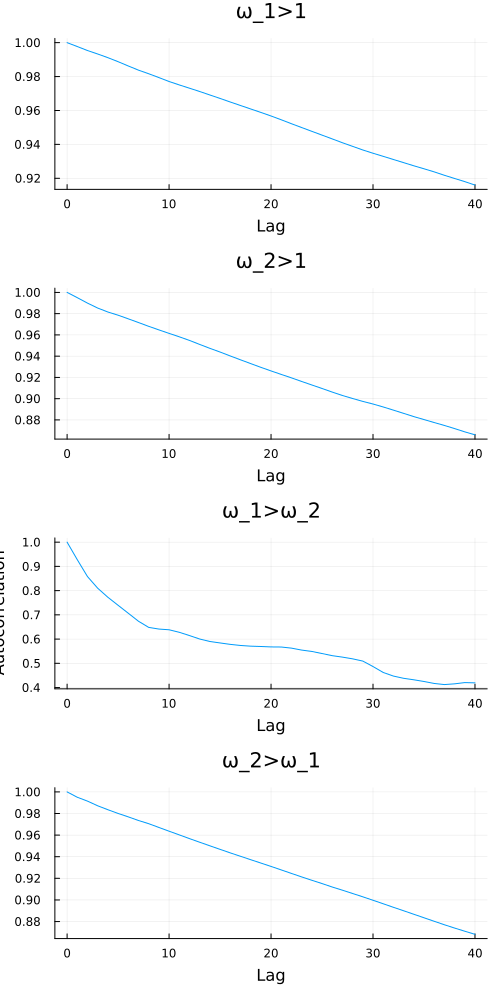

In [11]:
autocorplot(chn)

In [12]:
ess(chn)

ESS
  parameters       ess   ess_per_sec 
      Symbol   Float64       Missing 

       ω_1>1   24.7884       missing
       ω_2>1   30.3100       missing
     ω_1>ω_2   31.0369       missing
     ω_2>ω_1   36.3376       missing


Vector{Float64}


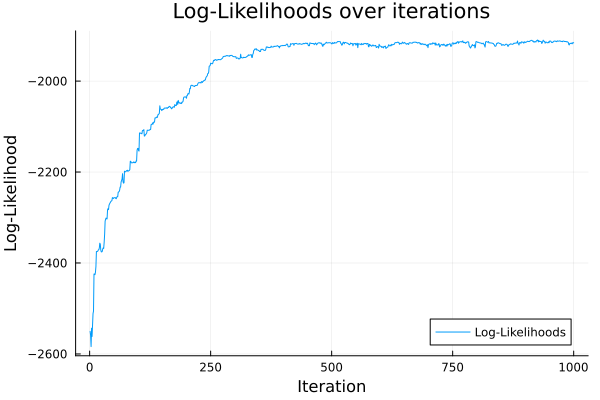

In [13]:
# Plot log-likelihoods

LL = [log_likelihood(model, sample) for sample in ambient_samples[1:1000]]
println(typeof(LL))
plot(1:length(LL), LL, label="Log-Likelihoods", title="Log-Likelihoods over iterations", xlabel="Iteration", ylabel="Log-Likelihood")
savefig("log_likelihoods.png")